# Introduction
We take the 2-layer MLP from previous video and make it deeper with a tree-like structure, arriving at a convolutional neural network architecture similar to the [WaveNet](https://arxiv.org/abs/1609.03499) (2016) from DeepMind.

# Libraries

In [1]:
%matplotlib inline
%config IPCompleter.use_jedi=False

In [2]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Data

### Reading the Data

In [23]:
# Reading names into a list
with open('../../data/names.txt', 'r') as f:
    names = f.readlines()
    names = [name.strip() for name in names]

### Creating Vocabulary

In [24]:
# Building the vocabulary (character to/from index)
chars = sorted(list(set(''.join(names))))
chr_to_idx = {s:i+1 for i,s in enumerate(chars)}; print(chr_to_idx)
chr_to_idx['.'] = 0
idx_to_chr = {i:s for s,i in chr_to_idx.items()}; print(idx_to_chr)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Building dataset
This time we use a longer block size of eight!

In [25]:
def build_dataset(words: list, block_size: int = 3, verbose: bool = False) -> tuple:
    """
    Description:
        Take a list of words and creates Xs and Ys give
        a block size. E.g. block_size=3 for emma would 
        result in:
            ... ---> e  
            ..e ---> m  
            .em ---> m  
            emm ---> a  
            mma ---> . 
        Stored in a (n, 3) tensor
    Inputs:
        words: List of words
        block_size: The context window
        verbose: Where to print the outputs
    Ouputs:
        A (n, block_size) tensor with Xs
        A (n) tensor with Ys
    """
    X, Y = [], []
    for word in words:
        if verbose:
            print(word)
        context = [0] * block_size
        for char in word + '.':
            idx = chr_to_idx[char]
            X.append(context)
            Y.append(idx)
            if verbose:
                print(''.join(idx_to_chr[i] for i in context), idx_to_chr[idx])
            context = context[1:] + [idx]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

In [26]:
# Putting names in random order
random.shuffle(names)

# Creating split indices
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

In [27]:
# Building training, validation and test sets
Xtr, Ytr = build_dataset(words=names[:n1], block_size=8); print(Ytr.size())
Xval, Yval = build_dataset(words=names[n1:n2], block_size=8); print(Yval.size())
Xtest, Ytest = build_dataset(words=names[n2:], block_size=8); print(Ytest.size())

torch.Size([182348])
torch.Size([22820])
torch.Size([22978])


In [65]:
# Example of x and y
for x,y in zip(Xtr[:20],Ytr[:20]):
    print(''.join(idx_to_chr[ix.item()] for ix in x), '-->', idx_to_chr[y.item()])

........ --> t
.......t --> h
......th --> e
.....the --> o
....theo --> s
...theos --> .
........ --> z
.......z --> e
......ze --> p
.....zep --> p
....zepp --> e
...zeppe --> l
..zeppel --> i
.zeppeli --> n
zeppelin --> .
........ --> b
.......b --> e
......be --> n
.....ben --> t
....bent --> l


# Network Building Blocks
We we just reuse the blocks we created in a previous notebook.

In [8]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        """ Initializes Weights """
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        """ Forward Pass """
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        """ Returning  All Parameters """
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [9]:
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        """ Initializing Batchnorm Weights """
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # Batchnorm Shift Parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # Running batchnorm Mean and Variance
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        """ Forward Pass and Buffers """
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [10]:
class Tanh:
    def __call__(self, x):
        """ Non-linearity """
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [11]:
class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        """ Initializing Embedding Weights """
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        """ Forward Pass """
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        """ Returning All Parameters """
        return [self.weight]

In [12]:
class Flatten:
  
    def __call__(self, x):
        """ Flattens Final Dimension """
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        """ Returning All Parameters """
        return []

In [13]:
class Sequential:
  
    def __init__(self, layers):
        """ Saves a Reference to the Layers """
        self.layers = layers

    def __call__(self, x):
        """ Calls Layers Iteratively """
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
        """ Returns All Parameters """
        return [p for layer in self.layers for p in layer.parameters()]

# Training a Network
Here we build a simple network and train it. It will be this network that we continously expand in the next notebook.

In [68]:
# Initializing Weights
n_embd = 10
n_hidden = 200
block_size = 8
vocab_size = len(chr_to_idx)

# Model
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# Adjusing initialization of layers
with torch.no_grad():
    # Making last layer less confident
    model.layers[-1].weight *= 0.1

# All parameters
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [75]:
max_steps = 200000
batch_size = 64
lr = 0.2
lossi = []

for step in range(max_steps):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    lr = lr if step < 150000 else 0.01
    for p in parameters:
        p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    if not step % 10000:
        print(f"{step:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 2.4770
  10000/ 200000: 2.1058
  20000/ 200000: 2.1665
  30000/ 200000: 2.3756
  40000/ 200000: 2.2776
  50000/ 200000: 2.1696
  60000/ 200000: 2.3039
  70000/ 200000: 2.1297
  80000/ 200000: 2.2175
  90000/ 200000: 2.2263
 100000/ 200000: 1.8780
 110000/ 200000: 2.0407
 120000/ 200000: 2.0550
 130000/ 200000: 2.0552
 140000/ 200000: 2.2802
 150000/ 200000: 2.2277
 160000/ 200000: 2.2036
 170000/ 200000: 2.5233
 180000/ 200000: 1.9296
 190000/ 200000: 2.4358


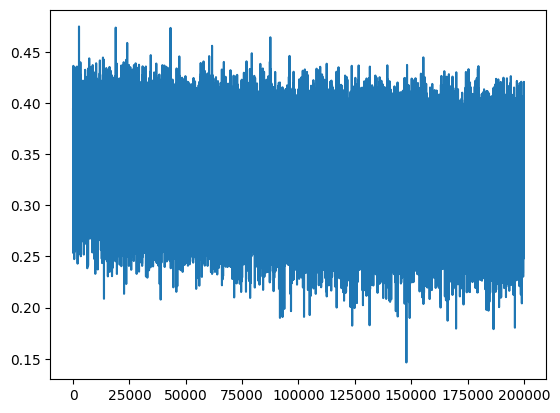

In [76]:
# Plotting loss
plt.plot(lossi)

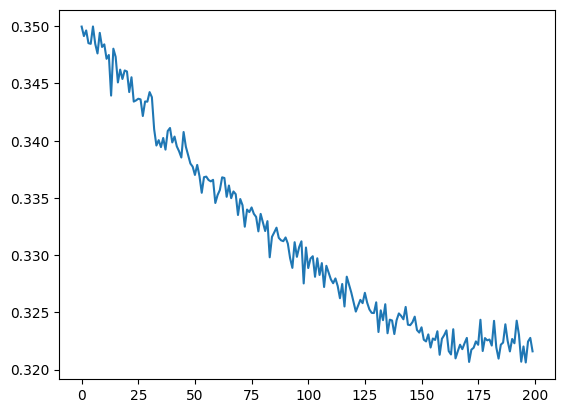

In [77]:
# Plotting a prettier loss
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [78]:
# Putting layers into eval mode
for layer in model.layers:
    layer.training = False

In [79]:
# Evaluating the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'valid': (Xval, Yval),
        'test': (Xtest, Ytest),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('valid')

train 2.1063363552093506
valid 2.1427969932556152


In [80]:
# Sampling from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        # Forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        
        # Sampling the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        
        # Shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        
        # If we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(idx_to_chr[i] for i in out))

jayleani.
armudano.
anellyah.
laxskir.
adhellia.
briaton.
jaurozaa.
marran.
omeando.
granoan.
mailal.
jori.
dali.
thyen.
sheajia.
ethanett.
mosio.
navermon.
radin.
makiman.


# The WaveNet Architecture
He we will slowly change the current architecture into the WaveNet architecture.

In [84]:
# Batch with four examples
idx = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[idx], Ytr[idx]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 10,  1],
        [ 0,  0,  0,  0, 10,  1, 26,  9],
        [ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  0,  0,  0,  0,  3]])

tensor([130604,  75697, 138533, 130456])

In [ ]:
#CONTINUE: http://www.youtube.com/watch?v=t3YJ5hKiMQ0&t=22m0s